<a href="https://colab.research.google.com/github/TheSpaceMan915/Artificial-Intelligence/blob/main/Lab13_Image_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Лабораторная работа №13  Колычев Никита  ВПР34**

In [ ]:
#@title Imports
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow as tf
import random
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras import Model
from tensorflow.keras.layers import InputLayer, Input, \
BatchNormalization, MaxPooling2D, Conv2DTranspose, UpSampling2D, \
Activation, Convolution2D, Conv2D, SeparableConv2D

# **Functions**

In [ ]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [ ]:
def load_image(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(
    datapoint['segmentation_mask'],
    (128, 128),
    method = tf.image.ResizeMethod.NEAREST_NEIGHBOR,
  )

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))
  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

In [ ]:
def plot_model_history(history_model):
    fig, (axes1, axes2) = plt.subplots(1, 2, figsize=(14, 5))
    plt.rcParams.update({"font.size": 14, "font.family": "serif"})

    axes1.plot(history_model.history["accuracy"], label="accuracy")
    axes1.plot(history_model.history["val_accuracy"], label="val_accuracy")
    axes1.set(title="Model accuracy")
    axes1.set(xlabel="Epoch")
    axes1.set(ylabel="Accuracy")
    axes1.legend(loc=4)

    axes2.plot(history_model.history["loss"], label="loss")
    axes2.plot(history_model.history["val_loss"], label="val_loss")
    axes2.set(title="Model loss")
    axes2.set(xlabel="Epoch")
    axes2.set(ylabel="Loss")
    axes2.legend(loc=1)

    fig.tight_layout()
    plt.savefig("plot_model_history{}".format(random.randint(0, 10000)))

In [ ]:
def get_unet_model(img_size, num_classes):
    # encoder
    # starting block
    inputs = Input(shape=img_size + (3,))
    x = Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    # saving the starting block
    previous_block_activation = x

    # creating the 1st, 2nd and 3rd blocks
    for filters in [64, 128, 256]:
        x = Activation("relu")(x)
        x = SeparableConv2D(filters, 3, padding="same")(x)
        x = BatchNormalization()(x)

        x = Activation("relu")(x)
        x = SeparableConv2D(filters, 3, padding="same")(x)
        x = BatchNormalization()(x)

        x = MaxPooling2D(3, strides=2, padding="same")(x)

        # adding the saved block
        residual = Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )

        # saving the blocks
        x = tf.keras.layers.add([x, residual])  
        previous_block_activation = x

    # decoder
    for filters in [256, 128, 64, 32]:
        x = Activation("relu")(x)
        x = Conv2DTranspose(filters, 3, padding="same")(x)
        x = BatchNormalization()(x)

        x = Activation("relu")(x)
        x = Conv2DTranspose(filters, 3, padding="same")(x)
        x = BatchNormalization()(x)

        x = UpSampling2D(2)(x)

        # adding the saved blocks
        residual = UpSampling2D(2)(previous_block_activation)
        residual = Conv2D(filters, 1, padding="same")(residual)
        x = tf.keras.layers.add([x, residual])  
        previous_block_activation = x 

    # adding the classifier
    outputs = Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # creating a model
    model = Model(inputs, outputs)
    return model

# **Classes**

In [ ]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

# **Задание 1**
Обучить полностью свёрточную нейронную сеть для сегментации на выбранном датасете.

In [ ]:
# loading the dataset
dataset, info = tfds.load("oxford_iiit_pet:3.*.*", with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompletePBTVTW/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompletePBTVTW/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [ ]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
NUMBER_CLASSES = 3

In [ ]:
# splitting the dataset and processing each image in the dataset
train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
# building a pipeline to batch the inputs and apply the augmentation
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(BATCH_SIZE)

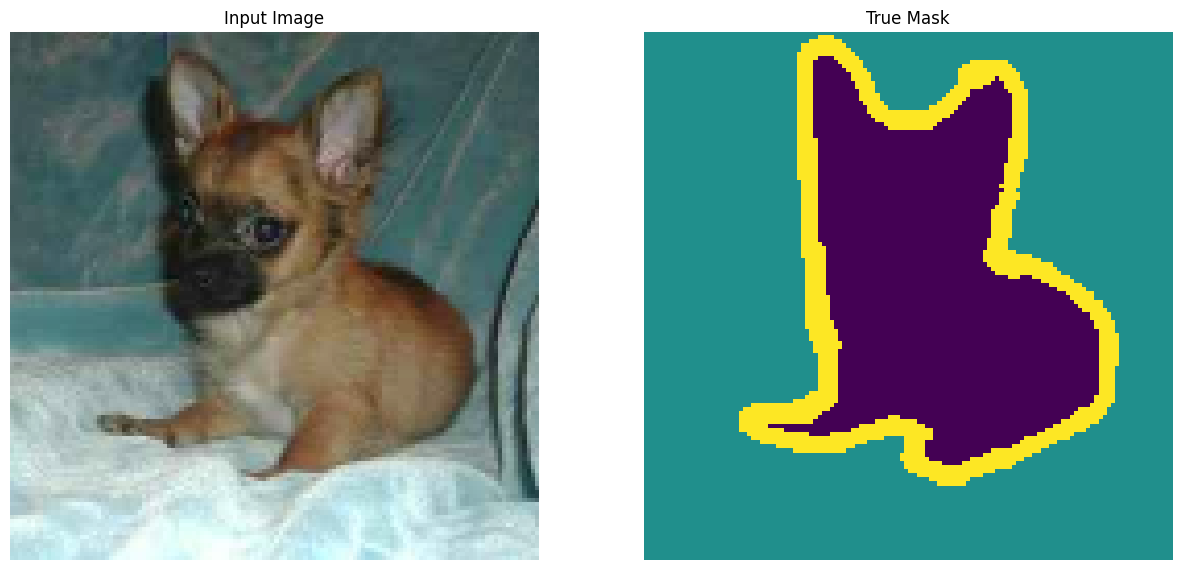

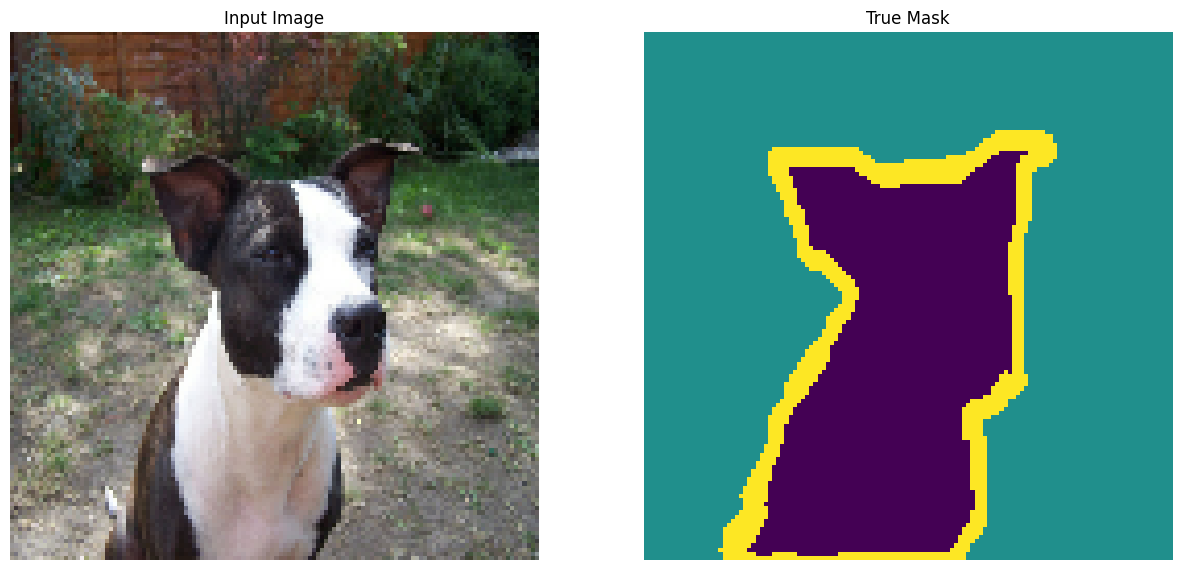

In [ ]:
for images, masks in train_batches.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

In [ ]:
# creating a model
model = Sequential([
    # encoder part
    InputLayer((128, 128, 3)),
    Convolution2D(filters=256, kernel_size=(3, 3), activation="relu", padding="same", kernel_initializer="he_uniform"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2), padding="same"),
    Convolution2D(filters=128, kernel_size=(3, 3), activation="relu", padding="same", kernel_initializer="he_uniform"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2), padding="same"),
    Convolution2D(filters=64, kernel_size=(3, 3), activation="relu", padding="same", kernel_initializer="he_uniform"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2), padding="same"),

    # decoder part
    UpSampling2D(size=(2, 2)),
    Convolution2D(filters=64, kernel_size=(3, 3), activation="relu", padding="same", kernel_initializer="he_uniform"),
    BatchNormalization(),
    UpSampling2D(size=(2, 2)),
    Convolution2D(filters=128, kernel_size=(3, 3), activation="relu", padding="same", kernel_initializer="he_uniform"),
    BatchNormalization(),
    Conv2DTranspose(NUMBER_CLASSES, 3, strides=2, padding="same")
])

model.compile(loss=SparseCategoricalCrossentropy(from_logits=True),
              optimizer="adam",
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 128, 128, 256)     7168      
                                                                 
 batch_normalization_20 (Bat  (None, 128, 128, 256)    1024      
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 64, 64, 256)      0         
 2D)                                                             
                                                                 
 conv2d_15 (Conv2D)          (None, 64, 64, 128)       295040    
                                                                 
 batch_normalization_21 (Bat  (None, 64, 64, 128)      512       
 chNormalization)                                                
                                                      

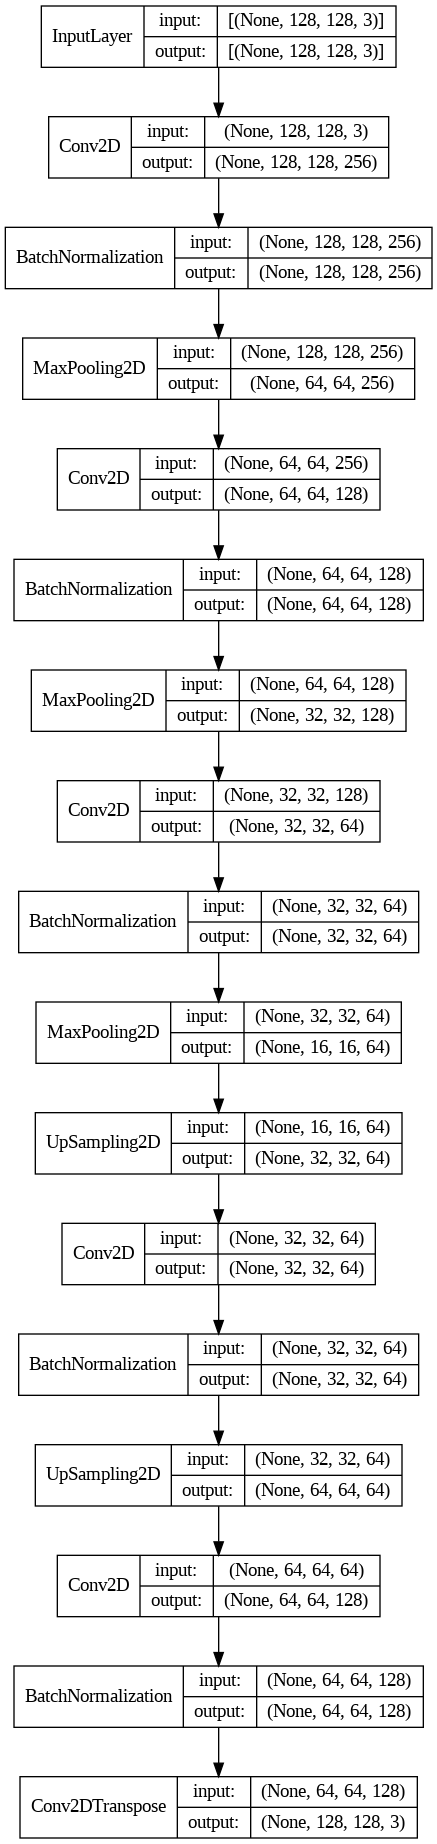

In [ ]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=False)

In [ ]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

In [ ]:
# fitting without any accelerators (took 8 hours 30 minutes to complete)
model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          verbose=1)

Epoch 1/20
57/57 [==============================] - 1692s 30s/step - loss: 0.8090 - accuracy: 0.6741 - val_loss: 1.1984 - val_accuracy: 0.5334
Epoch 2/20
57/57 [==============================] - 1844s 33s/step - loss: 0.6259 - accuracy: 0.7546 - val_loss: 0.9693 - val_accuracy: 0.5880
Epoch 3/20
57/57 [==============================] - 1692s 30s/step - loss: 0.5536 - accuracy: 0.7766 - val_loss: 0.8809 - val_accuracy: 0.6478
Epoch 4/20
57/57 [==============================] - 1629s 29s/step - loss: 0.5230 - accuracy: 0.7888 - val_loss: 0.9625 - val_accuracy: 0.6577
Epoch 5/20
57/57 [==============================] - 1618s 28s/step - loss: 0.4946 - accuracy: 0.8006 - val_loss: 0.8006 - val_accuracy: 0.6936
Epoch 6/20
57/57 [==============================] - 1620s 28s/step - loss: 0.4792 - accuracy: 0.8074 - val_loss: 0.7990 - val_accuracy: 0.7056
Epoch 7/20
57/57 [==============================] - 1650s 29s/step - loss: 0.4695 - accuracy: 0.8118 - val_loss: 0.6855 - val_accuracy: 0.7404

In [ ]:
# fitting on GPU (took 5 minutes to complete)
model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          verbose=1)

Epoch 1/20
57/57 [==============================] - 21s 275ms/step - loss: 0.8178 - accuracy: 0.6711 - val_loss: 0.9400 - val_accuracy: 0.5852
Epoch 2/20
57/57 [==============================] - 15s 267ms/step - loss: 0.6408 - accuracy: 0.7497 - val_loss: 0.9079 - val_accuracy: 0.6060
Epoch 3/20
57/57 [==============================] - 15s 258ms/step - loss: 0.5686 - accuracy: 0.7704 - val_loss: 0.8904 - val_accuracy: 0.6195
Epoch 4/20
57/57 [==============================] - 15s 257ms/step - loss: 0.5270 - accuracy: 0.7867 - val_loss: 0.6862 - val_accuracy: 0.7119
Epoch 5/20
57/57 [==============================] - 15s 266ms/step - loss: 0.5001 - accuracy: 0.7996 - val_loss: 0.6677 - val_accuracy: 0.7265
Epoch 6/20
57/57 [==============================] - 15s 265ms/step - loss: 0.4965 - accuracy: 0.7997 - val_loss: 0.8117 - val_accuracy: 0.6877
Epoch 7/20
57/57 [==============================] - 15s 265ms/step - loss: 0.4743 - accuracy: 0.8096 - val_loss: 0.5716 - val_accuracy: 0.7741

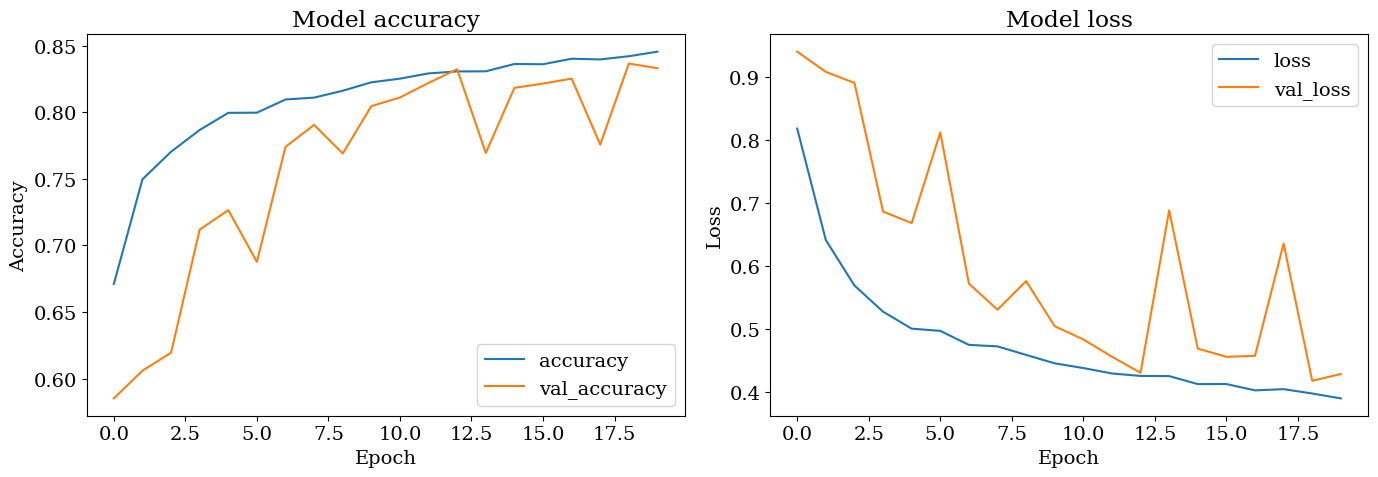

In [ ]:
plot_model_history(model_history)

# **Задание 2**
Реализуйте нейронную сеть архитектуры U-Net и выполните сегментацию для набора данных домашних питомцев.

In [ ]:
unet_model = get_unet_model((128, 128), NUMBER_CLASSES)
unet_model.compile(loss=SparseCategoricalCrossentropy(from_logits=True),
              optimizer="adam",
              metrics=['accuracy'])

unet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 32)   896         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

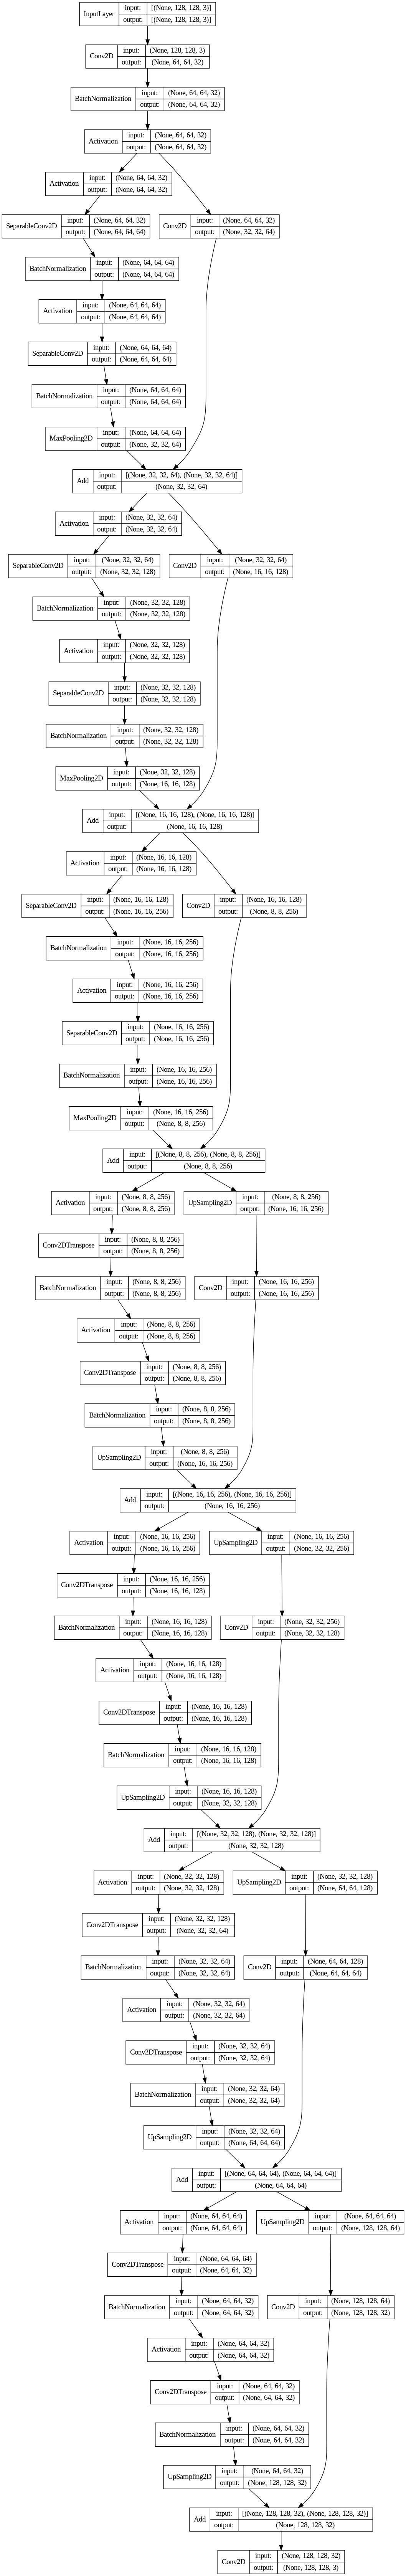

In [ ]:
tf.keras.utils.plot_model(unet_model, to_file='unet_model.png', show_shapes=True, show_layer_names=False)

In [ ]:
unet_model_history = unet_model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          verbose=1)

Epoch 1/20


/usr/local/lib/python3.9/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


57/57 [==============================] - 50s 285ms/step - loss: 1.4598 - accuracy: 0.6720 - val_loss: 4.7948 - val_accuracy: 0.5733
Epoch 2/20
57/57 [==============================] - 18s 266ms/step - loss: 0.6463 - accuracy: 0.7398 - val_loss: 4.5046 - val_accuracy: 0.5733
Epoch 3/20
57/57 [==============================] - 13s 234ms/step - loss: 0.6018 - accuracy: 0.7574 - val_loss: 4.4283 - val_accuracy: 0.5733
Epoch 4/20
57/57 [==============================] - 15s 266ms/step - loss: 0.5766 - accuracy: 0.7683 - val_loss: 5.3659 - val_accuracy: 0.5733
Epoch 5/20
57/57 [==============================] - 14s 241ms/step - loss: 0.5417 - accuracy: 0.7826 - val_loss: 3.4478 - val_accuracy: 0.5733
Epoch 6/20
57/57 [==============================] - 15s 269ms/step - loss: 0.5089 - accuracy: 0.7961 - val_loss: 4.6963 - val_accuracy: 0.5733
Epoch 7/20
57/57 [==============================] - 15s 269ms/step - loss: 0.4820 - accuracy: 0.8074 - val_loss: 4.4990 - val_accuracy: 0.5733
Epoch 8/20

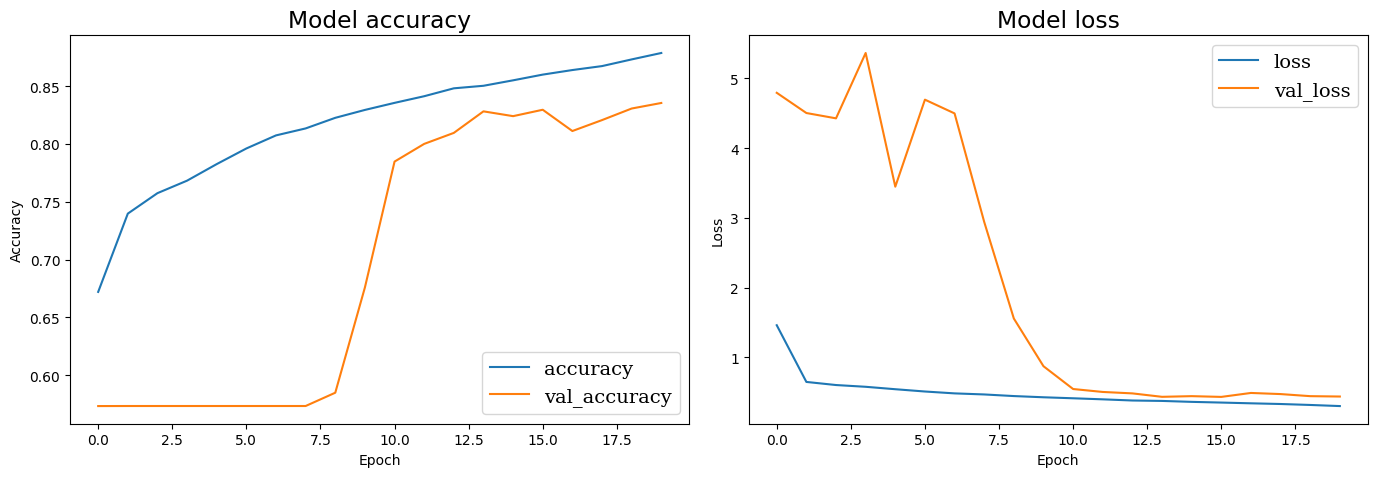

In [ ]:
plot_model_history(unet_model_history)